<a href="https://colab.research.google.com/github/xaximpvp2/master/blob/main/colab_ident_cooler_v240506.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encontrando um modelo matemático que descreve o comportamento do Cooler

Nesta atividade de programação, você usará os dados de PWM e de RPM para estimar um modelo matemático (rede neural) que desreve o comportamento do Cooler.

## Carregando os dados gravados com o serial plot

Primeiramente, iremos carregar os dados que foram gravados com o Serial Plot.

In [2]:
import numpy as np # Importa a biblioteca NumPy (uma biblioteca vastamente utilizada quando programamos em Python)

# Carregando o arquivo
nome_do_arquivo = '240210_dados_serialplot'
file  = open(f'{nome_do_arquivo}')
dados = np.loadtxt(file, delimiter=",")

# mostra as 10 primeiras linhas da matriz 'dados':

print(dados[:10,:])

[[3813.88  155.5 ]
 [3815.82  155.51]
 [3815.82  155.52]
 [3814.85  155.53]
 [3819.71  155.54]
 [3820.68  155.55]
 [3819.71  155.56]
 [3820.68  155.57]
 [3820.68  155.58]
 [3825.55  155.59]]


Note que a primeira coluna da matriz de dados diz respeito à velocidade (em rotações por minuto). Já a segunda coluna diz respeito à razão cíclica do pwm.

Para verificarmos a quantidade total de amostras, podemos usar o comando abaixo:

In [3]:
# faz print do tamanho dos dados:
print(f'Tamanho dos dados: ', dados.shape)

Tamanho dos dados:  (10022, 2)


Note que a matriz de dados possui 10022 linhas e 2 colunas. Cada linha representa um instante de tempo diferente. Cada coluna representa as grandezas que foram gravadas (no caso, velocidade e pwm).

Para separarmos as duas grandezas em dois vetores distintos, podemos usar os comandos abaixo:

In [4]:
y = dados[:,0] # Coloca todos os dados da primeira coluna num vetor 'y' que está sendo criado
u = dados[:,1] # Coloca todos os dados da segunda coluna num vetor 'u' que está sendo criado

# mostra as dez primeiras amostras em u
print('Primeiras 10 amostras do vetor u:', u[:10])

# mostra as dez primeiras amostras em y
print('Primeiras 10 amostras do vetor y:', y[:10])

Primeiras 10 amostras do vetor u: [155.5  155.51 155.52 155.53 155.54 155.55 155.56 155.57 155.58 155.59]
Primeiras 10 amostras do vetor y: [3813.88 3815.82 3815.82 3814.85 3819.71 3820.68 3819.71 3820.68 3820.68
 3825.55]


Abaixo, nós usamos a biblioteca matplotlib para fazermos um gráfico que mostra as variáveis u e y

Text(0.5, 0, 'Tempo [segundos]')

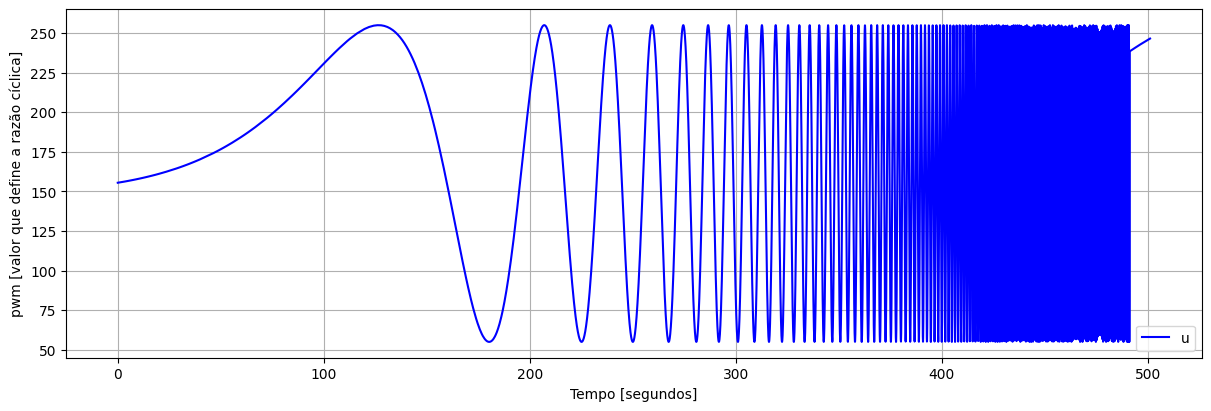

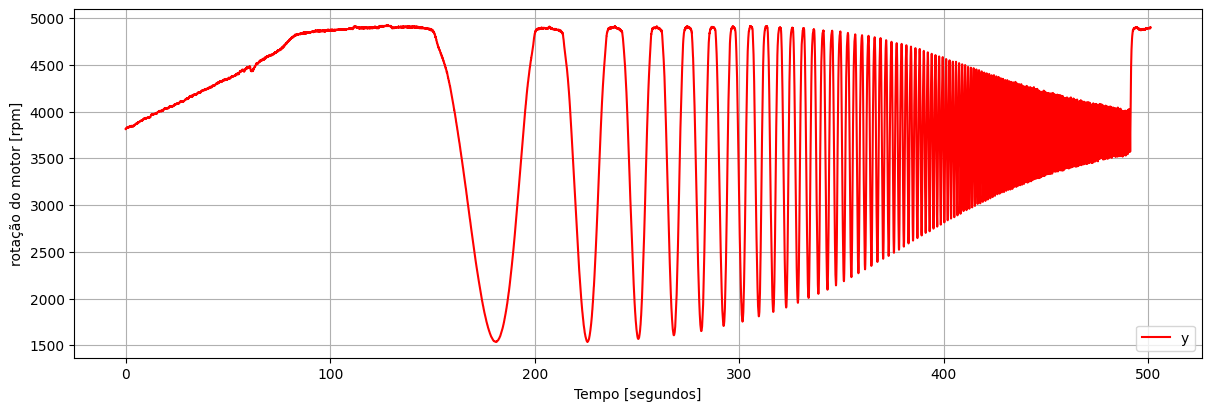

In [6]:
import matplotlib.pyplot as plt # importa a biblioteca matplotlib

Ts = 0.05 # Trata-se do período de amostragem (usar o mesmo que foi implementado no arduino uno)

K = len(y) # Captura o número total de amostras como sendo o tamanho do vetor 'y'

t = Ts*np.arange(K) # cria o vetor de tempo que será usado para plotar 'u' e 'y'

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12,4))
ax.plot(t,u, c='b', label = 'u')
ax.grid()
ax.legend(loc='lower right')
ax.set_ylabel('pwm [valor que define a razão cíclica]')
ax.set_xlabel('Tempo [segundos]')

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12,4))
ax.plot(t,y, c='r', label = 'y')
ax.grid()
ax.legend(loc='lower right')
ax.set_ylabel('rotação do motor [rpm]')
ax.set_xlabel('Tempo [segundos]')

Note que a ordem de grandeza da velocidade é diferente da ordem de grandeza dos valores de PWM. Como iremos trabalhar com redes neurais, é muito importante realizarmos um escalonamento desses valores, para que todos tenham uma ordem de grandeza apenas algumas poucas unidades.

O código abaixo faz justamente isso. Vale ainda destacar que, num contexto de aprendizado por reforço, a ação de controle (que no nosso caso é o pwm) é geralmente normalizada para que seus valores fiquem entre -1 e +1. Por outro lado, para normalizarmos a velocidade, simplesmente subtraímos um valor próximo à média dos valores observados e dividimos o resultado por um valor próximo ao desvio padrão.

In [7]:
u_novo  = (u-155)/100 # é equivalente à u_novo = 2*(u-u_min)/(u_max-u_min) - 1; onde u_min = 55 e u_max = 255
media_y = 3500 # valor aproximado da média das velocidades. Usei esse valor inteiro pois ele é fácil de recordar
std_y   = 500 # valor aproximado do desvio padrão das velocidades. Usei esse valor inteiro pois ele é fácil de recordar.
y_novo  = (y-media_y)/std_y
u       = u_novo
y       = y_novo

Se fizermos os gráficos novamente, iremos perceber que agora tanto a velocidade como o pwm variam dentro de intervalos de apenas algumas poucas unidades, ou seja, possuem a mesma ordem de grandeza.

Text(0.5, 0, 'Tempo [segundos]')

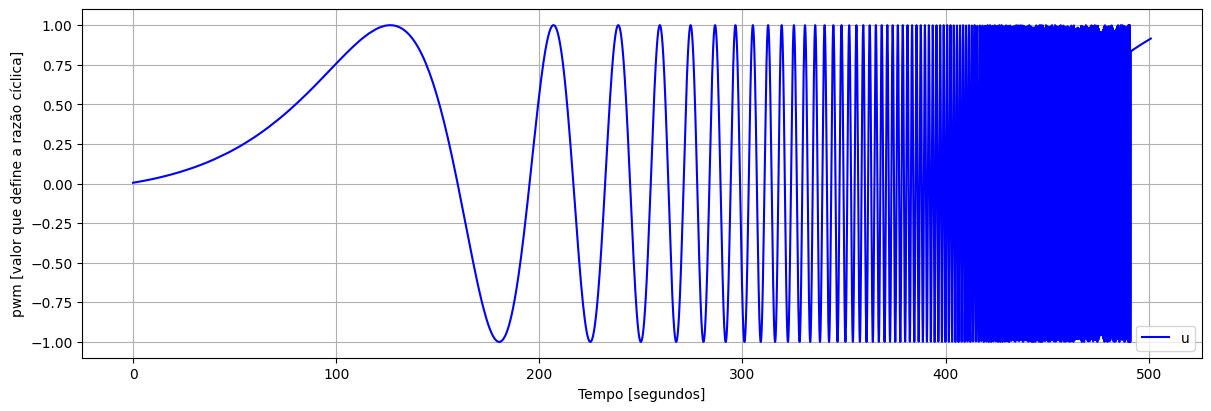

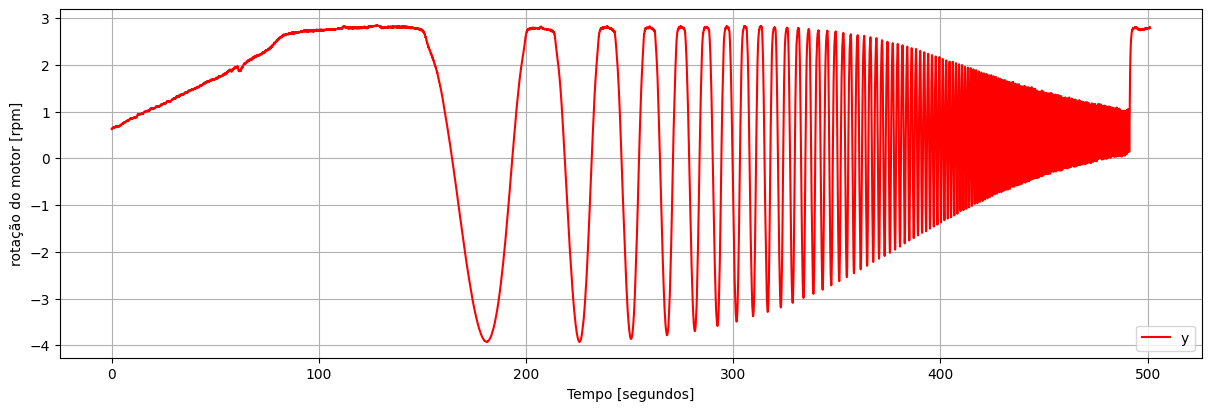

In [8]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12,4))
ax.plot(t,u, c='b', label = 'u')
ax.grid()
ax.legend(loc='lower right')
ax.set_ylabel('pwm [valor que define a razão cíclica]')
ax.set_xlabel('Tempo [segundos]')

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12,4))
ax.plot(t,y, c='r', label = 'y')
ax.grid()
ax.legend(loc='lower right')
ax.set_ylabel('rotação do motor [rpm]')
ax.set_xlabel('Tempo [segundos]')

Vale ainda destacar que, se quisermos obter o valor de velocidade na escala original, basta realizamos a operação inversa:

In [9]:
velocidade_normalizada = -3 # por exemplo, se quisermos descobrir quanto vale -3 em rotações por minuto

velocidade_rpm = velocidade_normalizada*std_y+media_y
print(velocidade_rpm)

2000


O mesmo raciocício vale para os valores de pwm:

In [10]:
pwm_normalizado = 0.0 # por exemplo, se quisermos descobrir quanto vale 0.0 na escala original

pwm  = pwm_normalizado*100 + 155
print(pwm)

155.0


Para que possamos treinar uma rede neural usando esses dados, precisamos ainda definir suas entradas e suas saídas.

Partiremos aqui de um princípio muito importante da modelagem de sistemas, que diz o seguinte: "se conhecemos o estado atual de um sistema e também qual ação queremos praticar nesse mesmo momento, é razoável que saibamos inferir acerca de qual será o próximo estado desse sistema"

No nosso contexto, isso pode ser interpretado da seguinte maneira: Se sabemos que o Cooler está rodando com uma velocidade de 3000 rpm no instante atual, e sabemos que queremos aplicar um pwm de 127 durante um período de amostragem, é razoável que com essas informações seja possível estimar qual será a nova velocidade do cooler após esse período de amostragem.

Note que, na interpretação acima, estamos assumindo que o estado do Cooler é a sua velocidade, e o pwm é a ação de controle passível de ser praticada com o objetivo de manipular esse estado.

Matematicamente, podemos dizer que, a partir de um par estado-ação ($s_t$,$a_t$), queremos um modelo que estime de forma adequada o próximo estado $s_{t+1}$. Ou ainda, usando as definições que já fizemos para $u$ e $y$, queremos definir $y_{t+1}$ a partir de ($y_t$,$u_t$).

Para treinarmos a rede neural, precisaremos então de uma matriz que contenha esses pares estado-ação ($y_t$,$u_t$) e os valores-alvo correspondentes $y_{t+1}$. Isso está sendo feito com o código abaixo.

In [11]:
XXX    = [] # matriz que conterá todos os pares estado-ação (s_t, a_t) possíveis de serem formados a partir dos dados coletados
yyy    = [] # vetor que conterá os valores-alvo correspondentes.

for k in range(1,K-1): # loop 'for' escrito em python. Começa com k=1 e termina com k=(K-1)-1
    y_dot    = y[k]-y[k-1]                    # representa a derivada da velocidade, ou seja, a taxa em que a velocidade está variando com o tempo. Também iremos incluir tal característica, apesar de não ter sido mencionado no texto acima.
    x_k      = np.array([y[k], y_dot, u[k]])  # contém [s_t a_t]: [rpm_atual, rpm_dot, pwm]
    y_k      = y[k+1]                         # contém [s_{t+1}]: [rpm_novo]

    XXX.append(x_k)
    yyy.append(y_k)

XXX = np.array(XXX)                 # transforma de lista para numpy array de duas dimensões (matriz)
yyy = np.array(yyy).reshape((-1,1)) # transforma de lista para numpy array de duas dimensões (matriz)

K_novo = XXX.shape[0] # o número pares (amostras) estado-ação formados a partir dos dados coletados:
print("Número de exemplos no conjunto de dados: ", K_novo)

Número de exemplos no conjunto de dados:  10020


Perceba como ficaram os tamanhos de `XXX` e `yyy`:

In [12]:
print("Tamanho da matriz de pares estado-ação: ", XXX.shape)
print("Tamanho do vetor contendo os valores-alvo correspondentes: ", yyy.shape)

Tamanho da matriz de pares estado-ação:  (10020, 3)
Tamanho do vetor contendo os valores-alvo correspondentes:  (10020, 1)


In [13]:
# abaixo mostramos o número de características
n = XXX.shape[1] # número de características = número de colunas da matriz XXX

print(f'número de características: {n}')

número de características: 3


Agora, o último passo que temos que cumprir antes de treinarmos o modelo é separar os dados em dois conjuntos: dados de estimação e dados de validação.

Os dados de estimação serão usados para treinar a rede neural. Já os dados de validação serão usados para verificar como a rede neural irá performar em cima de um conjunto de dados novo, ao qual ela não teve acesso durante seu treinamento.

Neste exemplo, usaremos 70% das nossas amostras para treinar e 30% das amostras para validar. Note-se que as amostras são selecionadas aleatoriamente para compor esses dois conjuntos de dados.

In [14]:
novas_posicoes_das_linhas  = np.random.permutation(K_novo)    # essa distribuição é feita de forma aleatória
fim_est                    = int(0.7*K_novo) # aproximadamente 70%
linhas_est                 = novas_posicoes_das_linhas[:fim_est] # vai de 0 até fim_est-1
linhas_val                 = novas_posicoes_das_linhas[fim_est:] # vai de fim_est até o fim do vetor

X_est                      = XXX[linhas_est,:]
y_est                      = yyy[linhas_est,:]
X_val                      = XXX[linhas_val,:]
y_val                      = yyy[linhas_val,:]

print("tamanho dos dados de estimação: ", X_est.shape, y_est.shape)
print("tamanho dos dados de validação: ", X_val.shape, y_val.shape)

tamanho dos dados de estimação:  (7014, 3) (7014, 1)
tamanho dos dados de validação:  (3006, 3) (3006, 1)


Agora finalmente estamos prontos para treinarmos uma rede neural usando os dados de estimação `X_est` e `y_est`. Nesse sentido, o primeiro passo consiste em carregar as funções existentes no Tensorflow.

In [15]:
import time
import tensorflow as tf # Tensorflow é uma biblioteca muito utilizada no contexto de aprendizado de máquina. Usaremos essa biblioteca para treinarmos nosso modelo (rede neural)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError

Abaixo nós definimos a estrutura da nossa rede neural. Note que ela possui 2 camadas intermediárias (cada uma com 4 neurônios) com ativação ReLU e sua camada de saída possui um único neurônio com ativação linear (afinal, estamos fazendo regressão e não classificação).

In [16]:
modelo = Sequential(
    [
        tf.keras.Input(shape=(n,)),
        Dense(4, activation="relu"), # note a quantidade de neurônios na primeira camada oculta
        Dense(4, activation="relu"), # note a quantidade de neurônios na segunda camada oculta
        Dense(1, activation="linear") # usamos linear pois trata-se de problema com regressão com valores positivos e negativos
    ], name = "meu_modelo"   # Na definição do nome do modelo, não pode haver espaços em branco
)

Se quisermos olhar a quantidade de parâmetros por camada, assim como a quantidade total de parâmetros do nosso modelo, basta usarmos o comando abaixo:

In [17]:
modelo.summary()

Model: "meu_modelo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Para treinarmos os parâmetros do modelo, usaremos o critério dos mínimos quadrados. Os comandos abaixo fazem isso:

In [18]:
tempo_inicial = time.time() # adquire tempo atual

modelo.compile(
        loss     = MeanSquaredError(),
        optimizer= tf.keras.optimizers.Adam(0.001),
    )
historico = modelo.fit(
    X_est,y_est,
    epochs=100
)

tempo_total = time.time() - tempo_inicial

print(f"\nTempo de treinamento: {tempo_total:.2f} s ({(tempo_total/60):.2f} min)")

Epoch 1/100
220/220 [==============================] - 3s 3ms/step - loss: 1.7479
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0754
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0370
Epoch 4/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0290
Epoch 5/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0222
Epoch 6/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0136
Epoch 7/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0094
Epoch 8/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0077
Epoch 9/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0066
Epoch 10/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 11/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0052
Epoch 12/100
220/220 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 13/100


O decréscimo no erro quadrático médio (MSE) ao longo das 100 épocas usadas para treinar o modelo também pode ser visto por meio do gráfico abaixo:

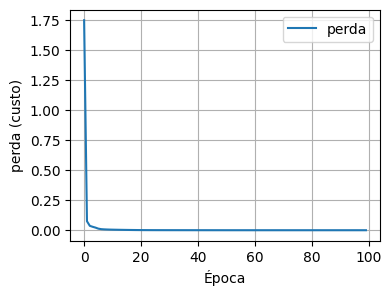

In [19]:
fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.plot(historico.history['loss'], label='perda')
#ax.set_ylim([0, 2])
ax.set_xlabel('Época')
ax.set_ylabel('perda (custo)')
ax.legend()
ax.grid(True)
plt.show()

Abaixo nós fazemos o cálculo da raiz quadrada do MSE (também chamada de RMS, do inglês, root mean square) e do coeficiente de determinação R2. Caso você não saiba o que essas figuras de mérito significam, faça uma consulta ao wikipedia, por exemplo.

In [20]:
# RMS e R2 para dados de estimação
y_est_hat   = modelo(X_est)
mse_est     = tf.math.reduce_mean(tf.math.square(y_est - y_est_hat))
rms_est     = tf.math.sqrt(mse_est)   # Calcula RMS
y_est_media = tf.math.reduce_mean(y_est)
den_est     = tf.math.reduce_mean(tf.math.square(y_est_media.numpy() - y_est_hat))
r2_est      = 100.0*(1-mse_est/den_est)
print(f"RMS estimação: {rms_est:.2f}. R2 estimação: {r2_est:.2f}")

RMS estimação: 0.02. R2 estimação: 99.98


Como o coeficiente R2 está próximo de 100 \%, significa que o nosso modelo está prevendo de forma bastante satisfatória a velocidade do Cooler.

Agora iremos verificar como esse nosso modelo performa para dados não vistos anteriormente. Ou seja, iremos recalcular essas métricas para o conjunto de dados de validação.

In [21]:
# RMS e R2 para dados de validação
y_val_hat   = modelo(X_val)
mse_val     = tf.math.reduce_mean(tf.math.square(y_val - y_val_hat))
rms_val     = tf.math.sqrt(mse_val)   # Calcula RMS
y_val_media = tf.math.reduce_mean(y_val)
den_val     = tf.math.reduce_mean(tf.math.square(y_val_media.numpy() - y_val_hat))
r2_val      = 100.0*(1-mse_val/den_val)
print(f"RMS validação: {rms_val:.2f}. R2 validação: {r2_val:.2f}")

RMS validação: 0.02. R2 validação: 99.98


Note que o modelo generalizou bem para os dados de validação, com um coeficiente R2 também próximo de 100 \%. Isso significa que temos um modelo matemático que modela satisfatoriamente o comportamento do nosso Cooler.

Também podemos visualizar como o nosso modelo estima temporalmente o conjunto completo dos dados em `XXX` e `yyy`:

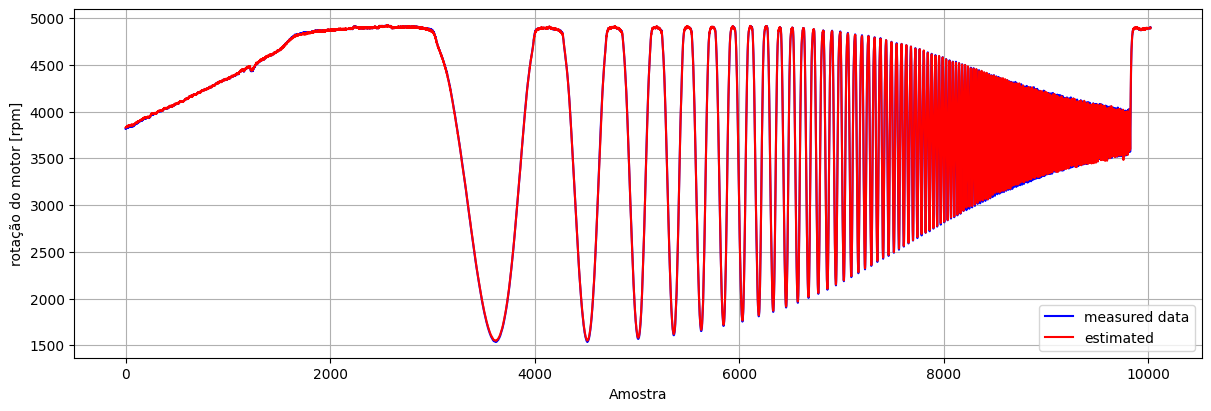

In [22]:
yyy_hat             = modelo(XXX)
yyy_hat_escala_orig = yyy_hat*std_y+media_y
yyy_escala_orig     = yyy*std_y+media_y

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12,4))
ax.plot(yyy_escala_orig, c='b', label = 'measured data')
ax.plot(yyy_hat_escala_orig, c='r', label = 'estimated')
ax.grid()
ax.legend(loc='lower right')
ax.set_ylabel('rotação do motor [rpm]')
ax.set_xlabel('Amostra')
fig.savefig('resultado_modelo.pdf', format='pdf')

Agora iremos verificar como o nosso modelo responde quando a entrada é um degrau no pwm, supondo que o cooler parte da velocidade -3 (ou seja, 2000 rpm).

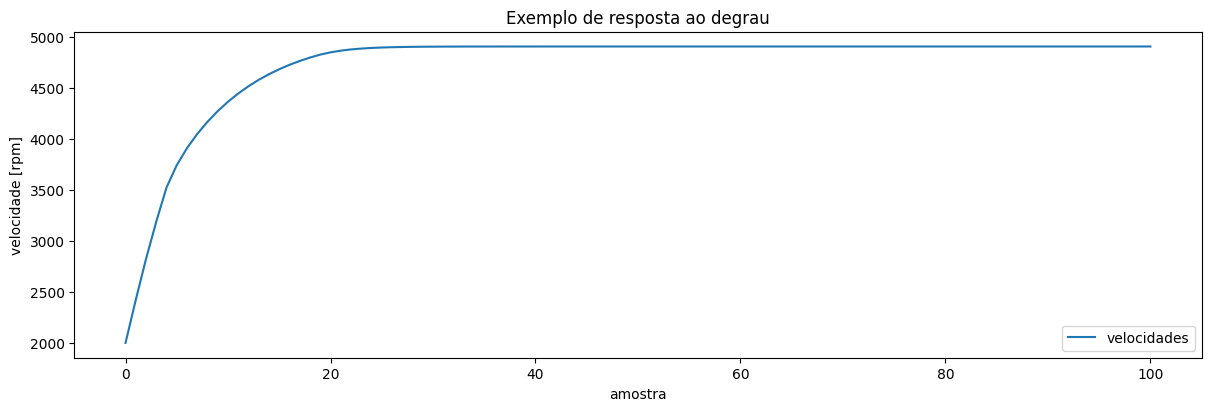

v(Inf) para pwm=255: 4904.17 rpm


In [23]:
pwm       = 1 # lembrando que 1 significa pwm=255 e -1 significa pwm=55
x_inicial = np.array([-3.0, 0.0, pwm]).reshape(1,-1)  # contém [s_t a_t]: [rpm_atual, rpm_dot, pwm]
x         = x_inicial

velocidades    = []
valores_de_pwm = []

velocidades.append(x[0][0]) # armazena velocidade inicial na lista criada
valores_de_pwm.append(pwm) # armazena valor inicial de pwm na lista criada

for t in range(100): # simularemos por 100 amostras (lembrando que Ts=0.05 segundo)
    rpm_novo     = modelo(x)[0][0]
    rpm_dot_novo = rpm_novo - x[0][0]  # contém [s_t a_t]: [rpm_atual, rpm_dot, pwm]
    x            = np.array([rpm_novo, rpm_dot_novo, pwm]).reshape(1,-1)  # contém [s_t a_t]: [rpm_atual, rpm_dot, pwm]

    velocidades.append(rpm_novo)
    valores_de_pwm.append(pwm)

velocidades    = 500*np.array(velocidades)+3500
valores_de_pwm = 100*np.array(valores_de_pwm) + 155

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(velocidades, label='velocidades')
ax.set_title("Exemplo de resposta ao degrau")
ax.legend(loc='lower right')
ax.set_ylabel('velocidade [rpm]')
ax.set_xlabel('amostra')
plt.show()

print(f'v(Inf) para pwm=255: {velocidades[-1]:.2f} rpm')

Abaixo fazemos o mesmo teste só que agora consideraremos um degrau no pwm de -1 (que significa 55)

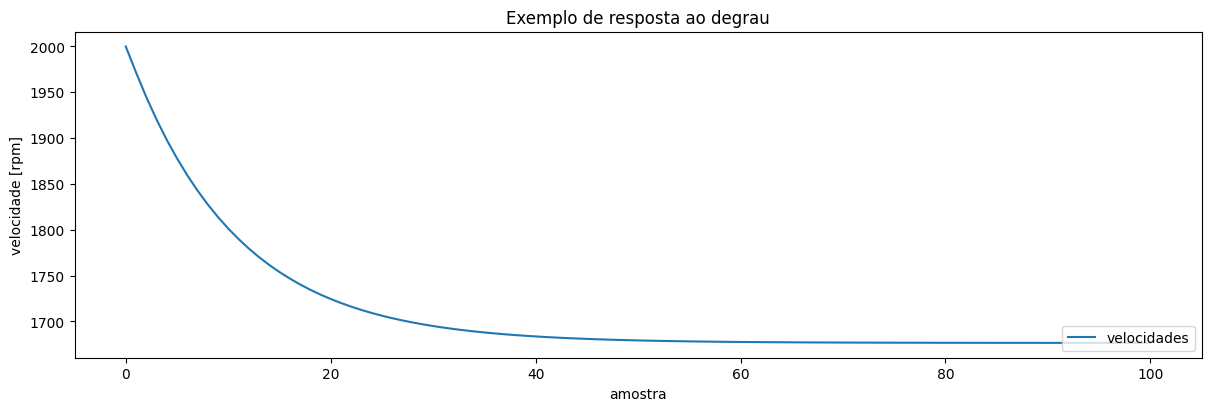

v(Inf) para pwm=55: 1676.47 rpm


In [24]:
pwm       = -1 # lembrando que -1 significa pwm=55
x_inicial = np.array([-3.0, 0.0, pwm]).reshape(1,-1)  # contém [s_t a_t]: [rpm_atual, rpm_dot, pwm]
x         = x_inicial

velocidades    = []
valores_de_pwm = []

velocidades.append(x[0][0]) # armazena velocidade inicial na lista criada
valores_de_pwm.append(pwm) # armazena valor inicial de pwm na lista criada

for t in range(100): # simularemos por 100 amostras (lembrando que Ts=0.05 segundo)
    rpm_novo     = modelo(x)[0][0]
    rpm_dot_novo = rpm_novo - x[0][0]  # contém [s_t a_t]: [rpm_atual, rpm_dot, pwm]
    x            = np.array([rpm_novo, rpm_dot_novo, pwm]).reshape(1,-1)  # contém [s_t a_t]: [rpm_atual, rpm_dot, pwm]

    velocidades.append(rpm_novo)
    valores_de_pwm.append(pwm)

velocidades    = 500*np.array(velocidades)+3500
valores_de_pwm = 100*np.array(valores_de_pwm) + 155

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(velocidades, label='velocidades')
ax.set_title("Exemplo de resposta ao degrau")
ax.legend(loc='lower right')
ax.set_ylabel('velocidade [rpm]')
ax.set_xlabel('amostra')
plt.show()

print(f'v(Inf) para pwm=55: {velocidades[-1]:.2f} rpm')

Agora iremos salvar a rede neural que nós treinamos. Afinal, precisaremos desse modelo para montarmos um ambiente de simulação que permita treinar um controlador para o Cooler. Isso será feito numa próxima atividade de programação.

In [25]:
modelo.save_weights("modelo_cooler.h5") # Note que esse comando cria um arquivo com extensão .h5 no diretório.

## Conclusões

Nessa atividade você conseguiu estimar um modelo matemático (rede neural) que descreve satisfatoriamente o comportamento de um sistema físico (cooler). Na próxima atividade de programação, você usará esse modelo para criar um ambiente de simulação que permita treinar um controlador para esse sistemas.